In [43]:
import time
import os
from os.path import join
import sys
import pandas as pd
import nibabel.freesurfer
from pathlib import Path

import numpy as np
import pyvista as pv
import torch

In [44]:
structure_id = 17  # Left-Hippocampus
brain_structure_filename = f"resliced_mesh_{structure_id}"
shapes_dir = Path('/Users/sak/.herbrain/data/pregnancy/neuromaternal_madrid_2021/derivatives/enigma_shape')

In [45]:
def nibabel_to_pyvista(mesh):
    V, F = mesh
    faces = np.hstack(np.c_[np.full(len(F), 3), F]).astype(np.int64)
    return pv.PolyData(V, faces)

In [46]:
import re

all_subject_meshes = {}

# Extract unique subject IDs
subject_ids = set()
for subdir in os.listdir(shapes_dir):
    # print(subdir)
    match = re.match(r"sub-(\w+)_ses-[34]", subdir)
    if match:
        # print("match!")
        subject_ids.add(match.group(1))

print(subject_ids)
print(len(subject_ids))
# session 3 corresponds to our 't0', meaning the data from the third trimester pregnancy
# session 4 corresponds to our 't1', meaning the postpartum data
for subject_id in sorted(subject_ids):
    sub_meshes = {}
    
    ses3_path = shapes_dir / f"sub-{subject_id}_ses-3" / "resliced_mesh_17"
    ses4_path = shapes_dir / f"sub-{subject_id}_ses-4" / "resliced_mesh_17"

    if not ses3_path.exists() or not ses4_path.exists():
        print("HELP :(")
        continue

    mesh3 = nibabel.freesurfer.read_geometry(str(ses3_path))
    mesh4 = nibabel.freesurfer.read_geometry(str(ses4_path))

    pv_mesh3 = nibabel_to_pyvista(mesh3)
    pv_mesh4 = nibabel_to_pyvista(mesh4)

    # Align ses-4 to ses-3
    aligned_mesh4 = pv_mesh4.align(
        pv_mesh3,
        max_landmarks=100,
        max_mean_distance=1e-5,
        max_iterations=500,
        check_mean_distance=True,
        start_by_matching_centroids=True,
    )

    sub_meshes['t0'] = pv_mesh3
    sub_meshes['t1'] = aligned_mesh4
    all_subject_meshes[subject_id] = sub_meshes

{'697823f5d8', 'e72d2b2eff', 'a9ae29e7b8', 'ed886bc0bd', '8029be34e5', 'eadc021f6f', '4cf50fd8bc', '31879f2221', '6fd380db03', '67eb38f7e9', 'c7b1145ac8', '6e5a9fb778', 'b627a7c635', '810e8bcfc7', '15255749dc', 'b63e08aef2', '3c4a4a2b19', 'f922d45e9a', 'deaeb431ad', '96fab186d7', '11a123772c', '0872b8db24', '4c1ea69777', '57622fa0f9', '26e0dc601b', 'b0d275dca1', '5356354624', '082dc070c1', 'bf028a52b9', 'de172debbf', '22cdbe0c1b', '74ad7c8895', '432c5fab2c', '7f2fe84ef2', '84be77a9cb', '254daf33ca', 'a8fd90daa4', '59580b610d', 'd4ed5fd5da', 'd367eabca4', '1db8e32656', '7304a751ea', '0a9b5eb6f1', '47fb269f0c', 'af0b71394f', 'e0e4067b5d', 'a0131fa8b8', '2d086560ad', '073801a359', '2edf82ffc5', '90e636662e', '9e143ef040', '17ca82ae03', '7b6707cd34', '690eec56c3', 'c4c18afc24', 'fcad4b7f8c', '5f42d47ec5', '8ccd1d5df7', 'e10934f7d6', '8d5824be35', '3cb6244806', '57747cb2eb', 'e7bbc362ec', 'c9a0ecdb96', '6b9079271c', 'ff91cacb30', '4f7098b19c', 'adcba77b1e', '948e10968e', 'f7a4c2297b', '471f

In [47]:
# load depression scores 
df = pd.read_csv("/Users/sak/.herbrain/data/pregnancy/old/czi_data_1st_upload_hggm/neuromaternal_madrid_2021/rawdata/participants_long_czi.tsv", sep='\t')

# make column with only participant id (remove 'sub-')
df['participant_id_clean'] = df['participant_id'].str.replace('sub-', '', regex=False)

# filter for healthy mothers in ses-4 with EDS < 10
healthy_df = df[
    (df['group'] == 'mother') &
    (df['EDS.Total'] < 10.) &
    (df['participant_id_ses'].str.endswith('ses-4'))
]

healthy_mother_ids = healthy_df["participant_id_clean"]

In [48]:
def average_pyvista_meshes(meshes):
    n_points = meshes[0].n_points
    
    stacked_vertices = np.stack([mesh.points for mesh in meshes if mesh is not None], axis=0)  # shape (n, m, 3)
    average_vertices = np.mean(stacked_vertices, axis=0)  # shape (m, 3)
    
    averaged_mesh = pv.PolyData(average_vertices, meshes[0].faces)
    
    return averaged_mesh

meshes = [all_subject_meshes[sub_id]['t0'] if sub_id in all_subject_meshes else print(f"Missing: {sub_id}") for sub_id in healthy_mother_ids]
# print(meshes)

average_brain = average_pyvista_meshes(meshes)

plotter = pv.Plotter()
plotter.add_mesh(average_brain, color="red", opacity=0.5)
plotter.show()

Widget(value='<iframe src="http://localhost:54423/index.html?ui=P_0x33067d150_2&reconnect=auto" class="pyvista…

In [49]:
trajectories = {}

for sub_id in all_subject_meshes:
    t1_mesh = all_subject_meshes[sub_id]['t1']
    
    # Compute the vertex-wise difference
    difference = t1_mesh.points - average_brain.points
    
    difference_mesh = average_brain.copy()
    difference_mesh['displacement'] = difference
    
    trajectories[sub_id] = difference_mesh


In [50]:
def compute_average_displacement(trajectory_mesh):
    disp_vectors = trajectory_mesh['displacement']
    magnitudes = np.linalg.norm(disp_vectors, axis=1) 
    return np.mean(magnitudes)

In [51]:
'''
EDS.Total is edinburgh depression score
right now i am only using the EDS from the second session (ses-4) to filter the depression diagnosis --
    my reasoning is that indicator of postpartum depression will be the score from the postpartum session even though they record it in the pregnant session as well

TODO: in the data, some mothers depression score increases and some decreases between sessions. some changes in score make diagnosis change -- e.g.:
    mother1 could be healthy in ses-3 and depressed in ses-4
    mother2 could be depressed in ses-3 and healthy in ses-4
    mother3 could be healthy in both sessions
    mother4 could be depressed in both sessions
    
how do we want to handle this in analysis?
'''

# only keep rows where we have trajectories
healthy_df = healthy_df[healthy_df['participant_id_clean'].isin(trajectories.keys())]

# now get EDS values 
healthy_magnitudes = []
healthy_eds_values = []

for _, row in healthy_df.iterrows():
    sub_id = row['participant_id_clean']
    if sub_id in trajectories:
        healthy_magnitudes.append(compute_average_displacement(trajectories[sub_id]))
        healthy_eds_values.append(row['EDS.Total'])

depressed_df = df[
    (df['group'] == 'mother') &
    (df['EDS.Total'] >= 10.) &
    (df['participant_id_ses'].str.endswith('ses-4'))
]
depressed_mother_ids = depressed_df["participant_id_clean"]

depressed_df = depressed_df[depressed_df['participant_id_clean'].isin(trajectories.keys())]

depressed_magnitudes = []
depressed_eds_values = []

for _, row in depressed_df.iterrows():
    sub_id = row['participant_id_clean']
    if sub_id in trajectories:
        depressed_magnitudes.append(compute_average_displacement(trajectories[sub_id]))
        depressed_eds_values.append(row['EDS.Total'])

In [52]:
# convert to numpy arrays
X_healthy = np.array(healthy_magnitudes).reshape(-1, 1)
y_healthy = np.array(healthy_eds_values)

X_depressed = np.array(depressed_magnitudes).reshape(-1, 1)
y_depressed = np.array(depressed_eds_values)

Healthy group:
  Slope: -0.101
  Intercept: 4.111
  R-squared: 0.003
Depressed group:
  Slope: -0.404
  Intercept: 14.782
  R-squared: 0.022


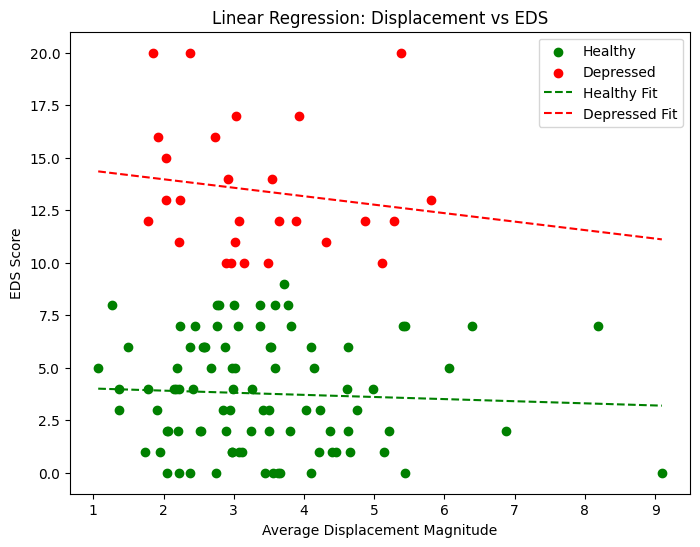

In [53]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# fit separate linear regressions
healthy_model = LinearRegression()
healthy_model.fit(X_healthy, y_healthy)

depressed_model = LinearRegression()
depressed_model.fit(X_depressed, y_depressed)

# slopes, intercepts, R-squared
print("Healthy group:")
print(f"  Slope: {healthy_model.coef_[0]:.3f}")
print(f"  Intercept: {healthy_model.intercept_:.3f}")
print(f"  R-squared: {healthy_model.score(X_healthy, y_healthy):.3f}")

print("Depressed group:")
print(f"  Slope: {depressed_model.coef_[0]:.3f}")
print(f"  Intercept: {depressed_model.intercept_:.3f}")
print(f"  R-squared: {depressed_model.score(X_depressed, y_depressed):.3f}")

plt.figure(figsize=(8, 6))

# Plot
plt.scatter(healthy_magnitudes, healthy_eds_values, color='green', label='Healthy')
plt.scatter(depressed_magnitudes, depressed_eds_values, color='red', label='Depressed')

# regression lines
x_vals = np.linspace(min(healthy_magnitudes + depressed_magnitudes),
                      max(healthy_magnitudes + depressed_magnitudes), 100).reshape(-1, 1)

plt.plot(x_vals, healthy_model.predict(x_vals), color='green', linestyle='--', label='Healthy Fit')
plt.plot(x_vals, depressed_model.predict(x_vals), color='red', linestyle='--', label='Depressed Fit')

plt.xlabel('Average Displacement Magnitude')
plt.ylabel('EDS Score')
plt.title('Linear Regression: Displacement vs EDS')
plt.legend()
plt.show()


T-statistic: 0.366, p-value: 0.716


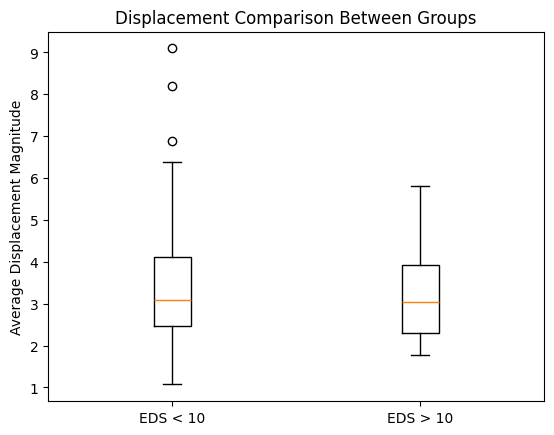

In [54]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(healthy_magnitudes, depressed_magnitudes, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")
plt.boxplot([healthy_magnitudes, depressed_magnitudes], tick_labels=['EDS < 10', 'EDS > 10'])
plt.ylabel('Average Displacement Magnitude')
plt.title('Displacement Comparison Between Groups')
plt.show()

In [55]:
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

d = cohens_d(healthy_magnitudes, depressed_magnitudes)
print(f"Cohen's d: {d:.3f}")

Cohen's d: 0.073


In [56]:
from scipy.stats import t

def mean_displacement_vector(trajectory_mesh):
    return np.mean(trajectory_mesh['displacement'], axis=0)  # (3,)

healthy_vectors = np.array([mean_displacement_vector(trajectories[sub_id]) for sub_id in healthy_mother_ids if sub_id in trajectories])
depressed_vectors = np.array([mean_displacement_vector(trajectories[sub_id]) for sub_id in depressed_mother_ids if sub_id in trajectories])

# Hotelling’s T² test (i took this function from chatgpt and didn't double check it)
def hotelling_t2(X, Y):
    n1, p = X.shape
    n2, _ = Y.shape

    mean1 = np.mean(X, axis=0)
    mean2 = np.mean(Y, axis=0)
    mean_diff = mean1 - mean2

    # Pooled covariance matrix
    S1 = np.cov(X, rowvar=False)
    S2 = np.cov(Y, rowvar=False)
    Sp = ((n1 - 1)*S1 + (n2 - 1)*S2) / (n1 + n2 - 2)

    # Hotelling’s T² statistic
    T2 = (n1 * n2) / (n1 + n2) * mean_diff @ np.linalg.inv(Sp) @ mean_diff

    # F-statistic equivalent
    F = (n1 + n2 - p - 1)*T2 / (p * (n1 + n2 - 2))
    df1 = p
    df2 = n1 + n2 - p - 1
    p_value = 1 - t.cdf(np.sqrt(F), df2)

    return T2, F, p_value

T2, F_stat, p_val = hotelling_t2(healthy_vectors, depressed_vectors)
print(f"Hotelling's T²: {T2:.3f}")
print(f"F-statistic: {F_stat:.3f}")
print(f"p-value: {p_val:.3f}")


Hotelling's T²: 1.797
F-statistic: 0.589
p-value: 0.222


In [57]:
from sklearn.decomposition import PCA

def flatten_displacement_field(trajectory_mesh):
    return trajectory_mesh['displacement'].flatten()

healthy_vectors = np.array([
    flatten_displacement_field(trajectories[sub_id])
    for sub_id in healthy_mother_ids if sub_id in trajectories
])
depressed_vectors = np.array([
    flatten_displacement_field(trajectories[sub_id])
    for sub_id in depressed_mother_ids if sub_id in trajectories
])

# PCA
all_data = np.vstack([healthy_vectors, depressed_vectors])
pca = PCA(n_components=10)  # First 10 PCs
scores = pca.fit_transform(all_data)

n_healthy = healthy_vectors.shape[0]
n_depressed = depressed_vectors.shape[0]
healthy_scores = scores[:n_healthy]
depressed_scores = scores[n_healthy:]

T2, F_stat, p_val = hotelling_t2(healthy_scores, depressed_scores)

print(f"Hotelling's T²: {T2:.3f}")
print(f"F-statistic: {F_stat:.3f}")
print(f"p-value: {p_val:.3f}")


Hotelling's T²: 7.643
F-statistic: 0.704
p-value: 0.202


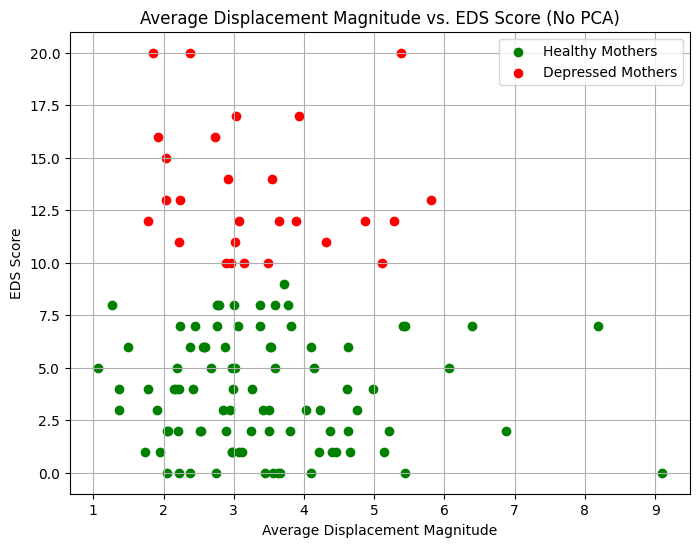

In [58]:
plt.figure(figsize=(8, 6))

# Plot average displacement magnitude vs EDS for each group
plt.scatter(healthy_magnitudes, healthy_eds_values, color='green', label='Healthy Mothers')
plt.scatter(depressed_magnitudes, depressed_eds_values, color='red', label='Depressed Mothers')

plt.xlabel('Average Displacement Magnitude')
plt.ylabel('EDS Score')
plt.title('Average Displacement Magnitude vs. EDS Score (No PCA)')
plt.legend()
plt.grid(True)
plt.show()


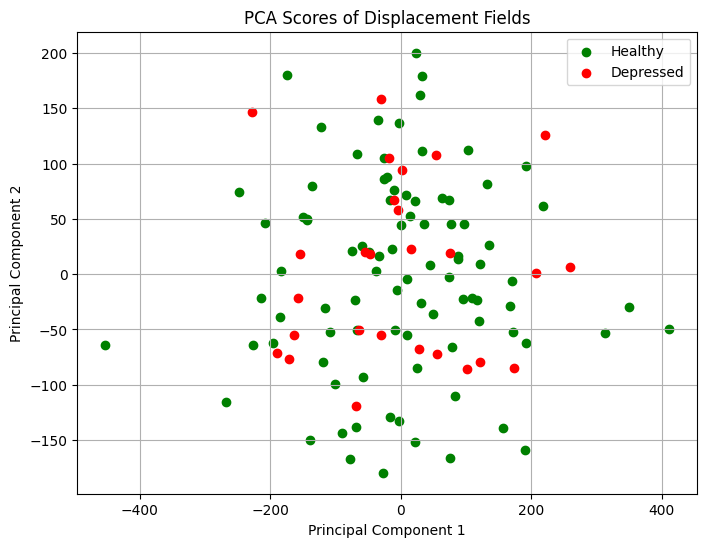

In [59]:
healthy_pc1 = healthy_scores[:, 0]
healthy_pc2 = healthy_scores[:, 1]

depressed_pc1 = depressed_scores[:, 0]
depressed_pc2 = depressed_scores[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(healthy_pc1, healthy_pc2, color='green', label='Healthy')
plt.scatter(depressed_pc1, depressed_pc2, color='red', label='Depressed')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scores of Displacement Fields')
plt.legend()
plt.grid(True)
plt.show()


Slope: -0.244, Intercept: 6.827, R-squared: 0.005


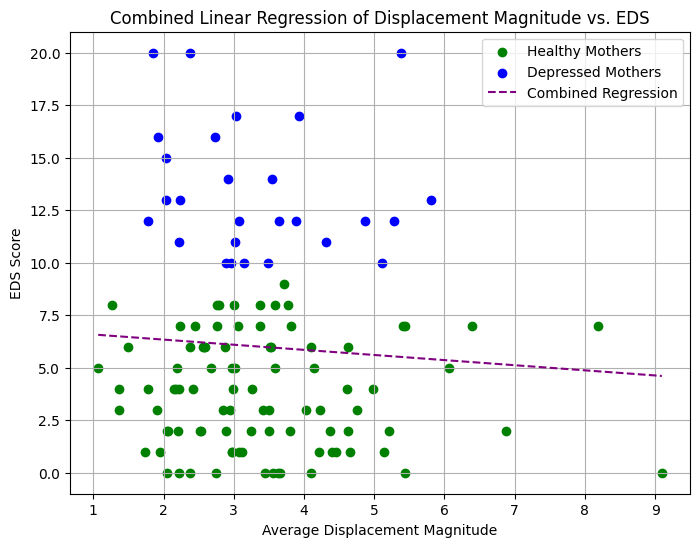

In [60]:
all_magnitudes = np.array(healthy_magnitudes + depressed_magnitudes).reshape(-1, 1)
all_eds_scores = np.array(healthy_eds_values + depressed_eds_values)

model = LinearRegression()
model.fit(all_magnitudes, all_eds_scores)

slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(all_magnitudes, all_eds_scores)

print(f"Slope: {slope:.3f}, Intercept: {intercept:.3f}, R-squared: {r_squared:.3f}")

plt.figure(figsize=(8, 6))

plt.scatter(healthy_magnitudes, healthy_eds_values, color='green', label='Healthy Mothers')
plt.scatter(depressed_magnitudes, depressed_eds_values, color='blue', label='Depressed Mothers')

x_vals = np.linspace(min(all_magnitudes)[0], max(all_magnitudes)[0], 100).reshape(-1, 1)
y_vals = model.predict(x_vals)
plt.plot(x_vals, y_vals, color='purple', linestyle='--', label='Combined Regression')

plt.xlabel('Average Displacement Magnitude')
plt.ylabel('EDS Score')
plt.title('Combined Linear Regression of Displacement Magnitude vs. EDS')
plt.legend()
plt.grid(True)

# save plot as svg 
plt.savefig('svgs/combined_regression_plot.svg', format='svg')
plt.show()


Accuracy: 0.496
ROC AUC: 0.512
Confusion Matrix:
[[42 48]
 [11 16]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.47      0.59        90
           1       0.25      0.59      0.35        27

    accuracy                           0.50       117
   macro avg       0.52      0.53      0.47       117
weighted avg       0.67      0.50      0.53       117



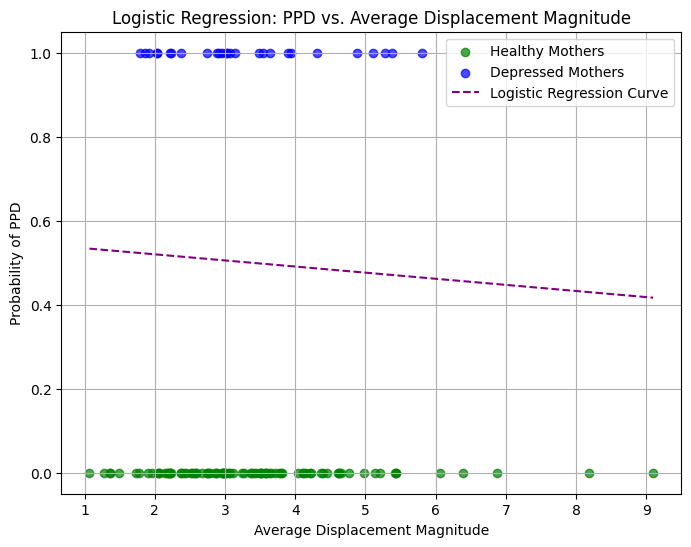

Predicted Labels: [0 1]
Label Counts: Counter({np.int64(0): 90, np.int64(1): 27})


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Prepare data
all_magnitudes = np.array(healthy_magnitudes + depressed_magnitudes).reshape(-1, 1)

# Create binary labels: 0 for healthy, 1 for depressed
labels = np.array([0]*len(healthy_magnitudes) + [1]*len(depressed_magnitudes))

# Logistic Regression Model
logreg_model = LogisticRegression(class_weight='balanced')
logreg_model.fit(all_magnitudes, labels)


# Model performance
predicted_labels = logreg_model.predict(all_magnitudes)
accuracy = accuracy_score(labels, predicted_labels)
roc_auc = roc_auc_score(labels, logreg_model.predict_proba(all_magnitudes)[:, 1])
conf_mat = confusion_matrix(labels, predicted_labels)

print(f"Accuracy: {accuracy:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print("Confusion Matrix:")
print(conf_mat)
print("Classification Report:")
print(classification_report(labels, predicted_labels))

# Visualize logistic curve
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.scatter(healthy_magnitudes, [0]*len(healthy_magnitudes), color='green', label='Healthy Mothers', alpha=0.7)
plt.scatter(depressed_magnitudes, [1]*len(depressed_magnitudes), color='blue', label='Depressed Mothers', alpha=0.7)

# Logistic curve
x_vals = np.linspace(min(all_magnitudes)[0], max(all_magnitudes)[0], 300).reshape(-1, 1)
y_probs = logreg_model.predict_proba(x_vals)[:, 1]

plt.plot(x_vals, y_probs, color='purple', linestyle='--', label='Logistic Regression Curve')

plt.xlabel('Average Displacement Magnitude')
plt.ylabel('Probability of PPD')
plt.title('Logistic Regression: PPD vs. Average Displacement Magnitude')
plt.legend()
plt.grid(True)

plt.savefig('svgs/logistic_regression_ppd.svg', format='svg')
plt.show()

print("Predicted Labels:", np.unique(predicted_labels))
from collections import Counter
print("Label Counts:", Counter(labels))